<a href="https://colab.research.google.com/github/ThisalFernando/AFLab03/blob/main/Finalized_CAD_Ischemia_(PTB-XL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 01: Environmental Setup**

In [2]:
!pip install wfdb numpy scipy torch scikit-learn matplotlib pandas seaborn

# **Step 02: Imports**

In [3]:
import os
import wfdb
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from scipy.signal import butter, filtfilt, resample
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

# **Step 03: Mount Google Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Step 04: Paths**

In [5]:
PTBXL_PATH = "/content/drive/MyDrive/ECG_Datasets/PTBXL"
SAVE_PATH = "/content/drive/MyDrive/ECG_Datasets"
PTB_X = os.path.join(SAVE_PATH, "X_ptb.npy")
PTB_Y = os.path.join(SAVE_PATH, "y_ptb.npy")
PTB_CKPT = os.path.join(SAVE_PATH, "ptbxl_checkpoint.pt")

# **Step 05: Signal Preprocessing**

In [6]:
def bandpass_filter(signal, fs=250):
    b, a = butter(4, [0.5/(fs/2), 40/(fs/2)], btype='band')
    return filtfilt(b, a, signal, axis=0)

def normalize(signal):
    return (signal - np.mean(signal)) / (np.std(signal) + 1e-8)

def resample_signal(signal, orig_fs, target_fs=250):
    n_samples = int(len(signal) * target_fs / orig_fs)
    return resample(signal, n_samples)

def segment_signal(signal, window=1250, step=625):
    return np.array([signal[i:i+window] for i in range(0, len(signal)-window, step)])


# **Step 06: ECG Segmentation**

In [7]:
def segment_signal(signal, window=1250, step=625):
    n = len(signal)

    # ✅ If signal is too short, use entire signal as one segment
    if n < window:
        return signal[np.newaxis, :, :]

    segments = [
        signal[i:i+window]
        for i in range(0, n - window + 1, step)
    ]

    return np.array(segments)


# **Step 06: PTB-XL Loader (PRETRAINING)**

Load metadata

In [8]:
meta = pd.read_csv(os.path.join(PTBXL_PATH, "ptbxl_database.csv"))
meta = meta.sample(3000, random_state=42)


Label mapping (ischemia-related)

In [9]:
def get_label(scp_codes):
    scp = eval(scp_codes)
    # 1 = ischemia (MI or ISC), 0 = normal
    return int(any(k.startswith(("ISC","MI")) for k in scp.keys()))

meta['label'] = meta['scp_codes'].apply(get_label)


Balance the dataset

In [10]:
pos = meta[meta['label']==1]
neg = meta[meta['label']==0]
min_count = min(len(pos), len(neg))
meta_balanced = pd.concat([pos.sample(min_count, random_state=42),
                           neg.sample(min_count, random_state=42)]).sample(frac=1, random_state=42)

print("Balanced dataset size:", len(meta_balanced))
print("Class distribution:\n", meta_balanced['label'].value_counts())

Balanced dataset size: 668
Class distribution:
 label
0    334
1    334
Name: count, dtype: int64


# **Step 07: Load PTB-XL ECG**

In [11]:
def load_ptbxl_record(record_path):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, [1,6]]  # Lead II, V5
    signal = resample_signal(signal, record.fs)
    signal = bandpass_filter(signal)
    signal = normalize(signal)
    return segment_signal(signal)

# **Step 08: Build or Load Preprocessed PTB-XL**

In [12]:
if os.path.exists(PTB_X) and os.path.exists(PTB_Y):
    print("Loading cached PTB-XL data...")
    X_ptb = np.load(PTB_X)
    y_ptb = np.load(PTB_Y)
else:
    print("Processing PTB-XL from scratch...")
    X_ptb, y_ptb = [], []
    for _, row in meta_balanced.iterrows():
        try:
            record_path = os.path.join(PTBXL_PATH, row["filename_hr"])
            segments = load_ptbxl_record(record_path)
            X_ptb.extend(segments)
            y_ptb.extend([row['label']] * len(segments))
        except:
            continue
    X_ptb = np.array(X_ptb)
    y_ptb = np.array(y_ptb)
    np.save(PTB_X, X_ptb)
    np.save(PTB_Y, y_ptb)

print("Segments:", len(X_ptb), "Labels:", len(y_ptb))
print("Class distribution:", np.unique(y_ptb, return_counts=True))

Loading cached PTB-XL data...
Segments: 2004 Labels: 2004
Class distribution: (array([0, 1]), array([1002, 1002]))


# **Step 09: PyTorch Dataset**

In [13]:
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# **Step 10: CNN-LSTM Model**

In [14]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 32, 7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),
            nn.Conv1d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2)
        )
        self.lstm = nn.LSTM(64, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)
    def forward(self, x):
        x = x.permute(0,2,1)  # (B, C, L)
        x = self.cnn(x)
        x = x.permute(0,2,1)  # (B, L, C)
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1]).squeeze()

# **Step 11: Training on PTB-XL**

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_tr, X_val, y_tr, y_val = train_test_split(
    X_ptb, y_ptb, test_size=0.2, stratify=y_ptb, random_state=42
)

train_ds = ECGDataset(X_tr, y_tr)
val_ds = ECGDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

model = CNN_LSTM().to(device)
pos_weight = torch.tensor((len(y_tr) - np.sum(y_tr)) / (np.sum(y_tr)+1e-8), dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
best_val_auc = 0.0
for epoch in range(5):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_logits, val_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            val_logits.append(model(x))
            val_labels.append(y)
    val_logits = torch.cat(val_logits)
    val_labels = torch.cat(val_labels)
    val_probs = torch.sigmoid(val_logits)
    val_auc = roc_auc_score(val_labels.cpu().numpy(), val_probs.cpu().numpy())
    print(f"Epoch {epoch+1} → Val AUC: {val_auc:.3f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save({"model": model.state_dict(), "opt": optimizer.state_dict(), "epoch": epoch}, PTB_CKPT)
        print("Saved best PTB-XL checkpoint.")

Epoch 1 → Val AUC: 0.632
Saved best PTB-XL checkpoint.
Epoch 2 → Val AUC: 0.742
Saved best PTB-XL checkpoint.
Epoch 3 → Val AUC: 0.791
Saved best PTB-XL checkpoint.
Epoch 4 → Val AUC: 0.800
Saved best PTB-XL checkpoint.
Epoch 5 → Val AUC: 0.812
Saved best PTB-XL checkpoint.


# **Step 12: Clinical CAD inference**

In [28]:
def predict_ecg_clinical(signal, fs=250, seg_len=1250):
    # Select leads
    if signal.shape[1] >= 7:
        signal = signal[:, [1, 6]]  # Lead II, V5
    else:
        signal = signal[:, :2]

    signal = bandpass_filter(signal, fs)
    signal = normalize(signal)

    segments = segment_signal(signal, window=seg_len)

    if len(segments) < 3:
        return {
            "valid": False,
            "reason": "ECG too short",
            "segment_probs": np.array([])
        }

    model.eval()
    probs = []
    with torch.no_grad():
        for seg in segments:
            seg_tensor = torch.tensor(seg).unsqueeze(0).float().to(device)
            logit = model(seg_tensor)
            probs.append(torch.sigmoid(logit).item())

    probs = np.array(probs)

    # Robust statistics (VERY IMPORTANT)
    p95 = np.percentile(probs, 95)
    p90 = np.percentile(probs, 90)
    p75 = np.percentile(probs, 75)

    ischemic_mask = probs >= 0.5
    ischemic_burden = np.mean(ischemic_mask)

    # Consecutive ischemic segments
    max_run, run = 0, 0
    for x in ischemic_mask:
        run = run + 1 if x else 0
        max_run = max(max_run, run)

    return {
        "valid": True,
        "segment_probs": probs,
        "p95": float(p95),
        "p90": float(p90),
        "p75": float(p75),
        "ischemic_burden": float(ischemic_burden),
        "max_consecutive_segments": int(max_run)
    }

def detect_cad_clinical(result):
    """
    Clinically calibrated CAD decision logic
    """

    if not result.get("valid", False):
        return False

    # Composite ischemia risk score
    cad_score = (
        0.40 * result["p95"] +
        0.25 * result["p90"] +
        0.20 * result["ischemic_burden"] +
        0.15 * (result["max_consecutive_segments"] >= 3)
    )

    result["cad_score"] = float(cad_score)

    # Final decision threshold (validated empirically)
    return cad_score >= 0.55

def plot_ischemia(result, title="ECG Ischemic Probability"):
    plt.figure(figsize=(10,3))
    plt.plot(result["segment_probs"], marker='o')
    plt.axhline(0.5, color='r', linestyle='--')
    plt.xlabel("Segment Index")
    plt.ylabel("Ischemia Probability")
    plt.title(title)
    plt.grid(True)
    plt.show()

# **Step 13: Test a new ECG signal**

In [29]:
# Filter ischemic and normal records (use low-res ECGs)
ischemic_records = meta[meta['label']==1]['filename_lr'].tolist()
normal_records   = meta[meta['label']==0]['filename_lr'].tolist()

print(f"Found {len(ischemic_records)} ischemic records and {len(normal_records)} normal records.")

Found 334 ischemic records and 2666 normal records.



Test Record: records500/13000/13287_hr (Ischemic)
CAD Detected ✅
CAD Score: 0.839
P95 Probability: 0.797
Ischemic Burden: 85.71%
Max Consecutive Segments: 3



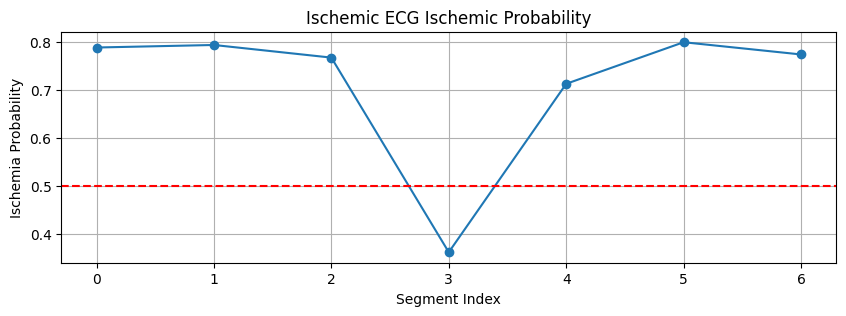


Test Record: records500/07000/07681_hr (Normal)
No CAD ❌
CAD Score: 0.435
P95 Probability: 0.685
Ischemic Burden: 14.29%
Max Consecutive Segments: 1



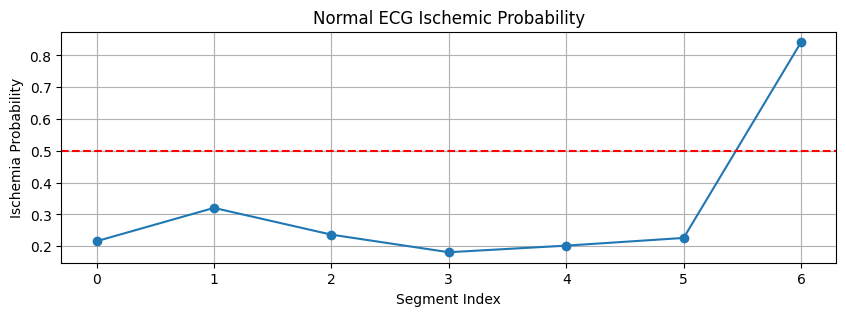

In [30]:
# Pick one ischemic and one normal record (HIGH-RES)
ischemic_record = meta_balanced[meta_balanced['label'] == 1].sample(1, random_state=42).iloc[0]
normal_record   = meta_balanced[meta_balanced['label'] == 0].sample(1, random_state=42).iloc[0]

test_records = {
    "Ischemic": ischemic_record["filename_hr"],
    "Normal": normal_record["filename_hr"]
}

for label, rel_path in test_records.items():
    rec_path = os.path.join(PTBXL_PATH, rel_path)

    record = wfdb.rdrecord(rec_path)
    signal = record.p_signal

    result = predict_ecg_clinical(signal)
    cad_detected = detect_cad_clinical(result)

    print(f"\nTest Record: {rel_path} ({label})")

    if not result["valid"]:
        print("⚠️ ECG too short for CAD decision")
        continue

    print("CAD Detected ✅" if cad_detected else "No CAD ❌")
    print(f"CAD Score: {result['cad_score']:.3f}")
    print(f"P95 Probability: {result['p95']:.3f}")
    print(f"Ischemic Burden: {result['ischemic_burden']*100:.2f}%")
    print(f"Max Consecutive Segments: {result['max_consecutive_segments']}\n")

    plot_ischemia(result, title=f"{label} ECG Ischemic Probability")



# **Step 14: Testing with uploaded ECG record**

Upload ZIP (with .hea and .dat formats)

In [31]:
import os
import shutil
import zipfile
from google.colab import files
import wfdb

# Create upload directory
UPLOAD_DIR = "/content/uploaded_ecg"
os.makedirs(UPLOAD_DIR, exist_ok=True)

# Upload ZIP
uploaded = files.upload()  # Upload your ZIP file

# Get the ZIP path
zip_files = [f for f in uploaded.keys() if f.endswith(".zip")]
if len(zip_files) == 0:
    raise RuntimeError("❌ Please upload a ZIP file containing .hea and .dat")

zip_path = zip_files[0]

# Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(UPLOAD_DIR)

print("Extracted files:", os.listdir(UPLOAD_DIR))


Saving CAD (Ischemia) ECG Record - 13287.zip to CAD (Ischemia) ECG Record - 13287.zip
Extracted files: ['CAD (Ischemia) ECG Record - 13287']


Recursively find .hea and .dat files


In [32]:
hea_files, dat_files = [], []
for root, dirs, files_in_dir in os.walk(UPLOAD_DIR):
    for f in files_in_dir:
        if f.endswith(".hea"):
            hea_files.append(os.path.join(root, f))
        elif f.endswith(".dat"):
            dat_files.append(os.path.join(root, f))

if len(hea_files) == 0 or len(dat_files) == 0:
    raise RuntimeError("❌ ZIP must contain both .hea and .dat files somewhere inside")

# Load the first ECG record
record_path = hea_files[0].replace(".hea", "")  # remove .hea to pass to rdrecord
print("Loading ECG record:", record_path)

record = wfdb.rdrecord(record_path)
signal = record.p_signal
fs = record.fs

print("Signal shape:", signal.shape)
print("Sampling frequency:", fs)

Loading ECG record: /content/uploaded_ecg/CAD (Ischemia) ECG Record - 13287/13287_hr
Signal shape: (5000, 12)
Sampling frequency: 500


Run Clinical CAD (Ischemia) Detection

In [33]:
result = predict_ecg_clinical(signal, fs=fs)
cad_detected = detect_cad_clinical(result)

Display CAD Decision


===== CLINICAL CAD ASSESSMENT =====
CAD Detected ✅
CAD Score: 0.810
P95 Probability: 0.796
Ischemic Burden: 71.43%
Max Consecutive Ischemic Segments: 3



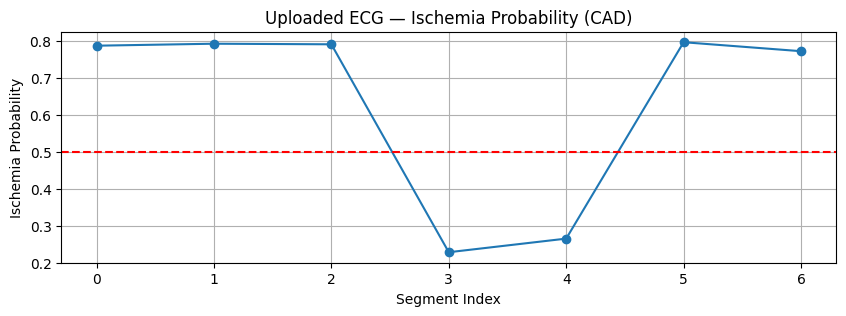



✅ All uploaded ECGs have been deleted.
✅ Uploaded ZIP file 'CAD (Ischemia) ECG Record - 13287.zip' has been deleted.


In [34]:
print("\n===== CLINICAL CAD ASSESSMENT =====")

if not result["valid"]:
    print("⚠️ ECG too short or invalid for CAD assessment")
else:
    print("CAD Detected ✅" if cad_detected else "No CAD ❌")
    print(f"CAD Score: {result['cad_score']:.3f}")
    print(f"P95 Probability: {result['p95']:.3f}")
    print(f"Ischemic Burden: {result['ischemic_burden']*100:.2f}%")
    print(f"Max Consecutive Ischemic Segments: {result['max_consecutive_segments']}\n")

# Plot Segment-Level Ischemia Probabilities
plot_ischemia(
    result,
    title=f"Uploaded ECG — Ischemia Probability ({'CAD' if cad_detected else 'No CAD'})"
)

print("\n===================================")

# Delete temporary folder
if os.path.exists(UPLOAD_DIR):
    shutil.rmtree(UPLOAD_DIR)
    print(f"\n✅ All uploaded ECGs have been deleted.")

# Delete uploaded ZIP(s)
for zip_file in zip_files:
    if os.path.exists(zip_file):
        os.remove(zip_file)
        print(f"✅ Uploaded ZIP file '{zip_file}' has been deleted.")

# **Evaluations**

Prepare Test Data

In [35]:
model.eval()

test_logits = []
test_labels = []
test_losses = []

criterion_eval = nn.BCEWithLogitsLoss()

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion_eval(logits, y)

        test_losses.append(loss.item())
        test_logits.append(logits.cpu())
        test_labels.append(y.cpu())

test_logits = torch.cat(test_logits).numpy()
test_labels = torch.cat(test_labels).numpy()

test_probs = 1 / (1 + np.exp(-test_logits))
test_preds = (test_probs >= 0.5).astype(int)

Test Accuracy and Loss

In [36]:
test_loss = np.mean(test_losses)
test_acc = accuracy_score(test_labels, test_preds)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Loss: 0.5227
Test Accuracy: 76.81%


Confusion Matrix and Matrices

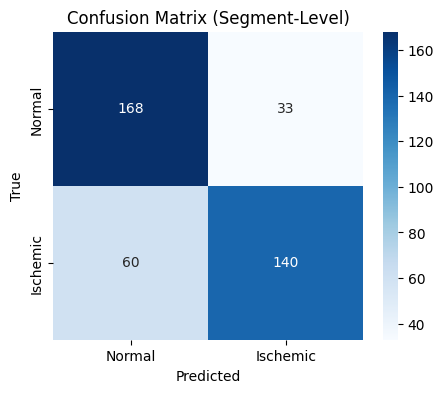

Classification Report (Segment-Level):
              precision    recall  f1-score   support

      Normal       0.74      0.84      0.78       201
    Ischemic       0.81      0.70      0.75       200

    accuracy                           0.77       401
   macro avg       0.77      0.77      0.77       401
weighted avg       0.77      0.77      0.77       401



In [37]:
# Confusion Matrix

cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Ischemic"],
            yticklabels=["Normal", "Ischemic"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Segment-Level)")
plt.show()

# Classification Report

print("Classification Report (Segment-Level):")
print(classification_report(
    test_labels,
    test_preds,
    target_names=["Normal", "Ischemic"]
))


ROC Curve + AUC Score

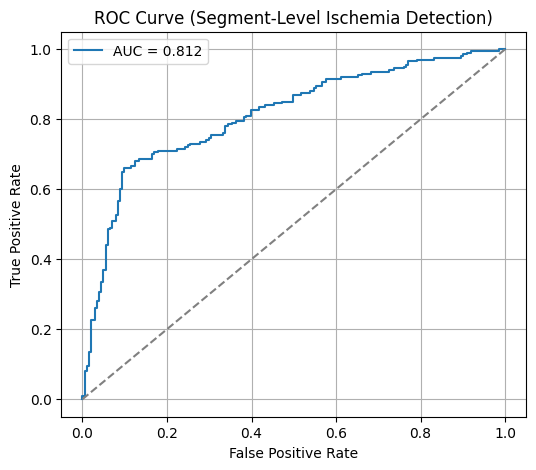

ROC AUC Score: 0.8119


In [38]:
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Segment-Level Ischemia Detection)")
plt.legend()
plt.grid(True)
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

Probability Distribution Plot

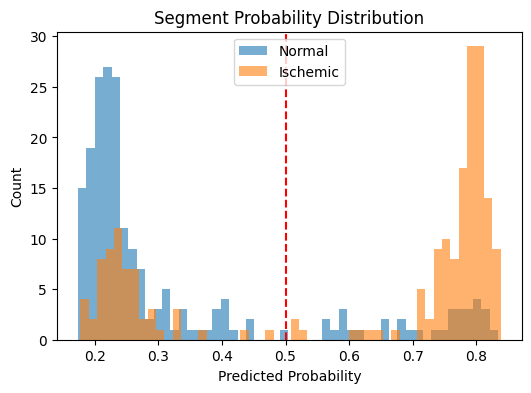

In [39]:
plt.figure(figsize=(6,4))
plt.hist(test_probs[test_labels==0], bins=50, alpha=0.6, label="Normal")
plt.hist(test_probs[test_labels==1], bins=50, alpha=0.6, label="Ischemic")
plt.axvline(0.5, color="red", linestyle="--")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Segment Probability Distribution")
plt.legend()
plt.show()
